# Exploring meta-data

In [5]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
DATA_DIR = "../Data/Grain-Data-RGB"

In [3]:
def load_and_clean_files(files_dir):
    files = os.listdir(files_dir)
    if ".DS_Store" in files:
        files.remove(".DS_Store")
    return files

def extract_metadata(filename):
    """
    Extracts metadata from filename
    """
    grain_match = re.search(r"grain(?P<grainID>\d+)", filename)
    var_match   = re.search(r"var(?P<varietyNumber>\d+)", filename)
    micro_match = re.search(r"x(?P<x>\d+)y(?P<y>\d+)", filename)
    time_match  = re.search(
        r"2x_(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})T(?P<timestamp>\d+)_corr",
        filename
    )

    if not all([grain_match, var_match, micro_match, time_match]):
        return None

    return {
        "grainID": grain_match.group("grainID"),
        "varietyNumber": var_match.group("varietyNumber"),
        "microplotID": f"x{micro_match.group('x')}y{micro_match.group('y')}",
        "year": time_match.group("year"),
        "month": time_match.group("month"),
        "day": time_match.group("day"),
        "timestamp": time_match.group("timestamp"),
        "filename": filename
    }


In [6]:
# Load data files
data_files_rgb = load_and_clean_files(DATA_DIR)

In [7]:
# Extract metadata from filenames
all_metadata = [extract_metadata(file) for file in data_files_rgb if extract_metadata(file)]

In [8]:
# convert metadata to pandas dataframe
df = pd.DataFrame(all_metadata)
df

,grainID,varietyNumber,microplotID,year,month,day,timestamp,filename
0,23632,7,x72y15,2021,10,23,144229,grain23632_var7-x72y15_7000_us_2x_2021-10-23T1...
1,7795,6,x40y20,2020,12,02,134036,grain7795_x40y20-var6_8000_us_2x_2020-12-02T13...
2,7511,5,x39y20,2020,12,02,131556,grain7511_x39y20-var5_8000_us_2x_2020-12-02T13...
3,16801,2,x76y12,2021,10,19,160332,grain16801_var2-x76y12_7000_us_2x_2021-10-19T1...
4,7613,5,x39y20,2020,12,02,132032,grain7613_x39y20-var5_8000_us_2x_2020-12-02T13...
...,...,...,...,...,...,...,...,...
26877,23093,6,x80y20,2021,10,19,150717,grain23093_var6-x80y20_7000_us_2x_2021-10-19T1...
26878,18368,3,x81y18,2021,10,23,150202,grain18368_var3-x81y18_7000_us_2x_2021-10-23T1...
26879,15566,2,x73y16,2021,10,19,155300,grain15566_var2-x73y16_7000_us_2x_2021-10-19T1...
26880,14254,1,x73y14,2021,10,23,151816,grain14254_var1-x73y14_7000_us_2x_2021-10-23T1...


In [11]:
# Save df to csv
df.to_csv("../Data/Grain-Data-RGB.csv", index=False)

# Exploring data
Loading random data files and visualizing them

In [9]:
def load_data(dir, filename):
    return np.load(os.path.join(dir, filename))

def band_brightness_npz(cube, k):
    """Approximation of the original Spectralon normalization."""
    band = cube[:, :, k]
    # avoid division by zero
    return np.mean(band) if np.mean(band) != 0 else 1.0


def plot_random_data(files, dir):
    N = 20
    sample_files = random.sample(files, N)
    cols = 5                   
    rows = math.ceil(N / cols) 

    plt.figure(figsize=(cols * 1.0, rows * 1.0))

    for i, f in enumerate(sample_files, 0):
        data = load_data(dir=dir, filename=f)
        img = data["x"]
        # Apply per-band brightness correction
        r = img[:, :, 0] / band_brightness_npz(img, 0)
        g = img[:, :, 1] / band_brightness_npz(img, 1)
        b = img[:, :, 2] / band_brightness_npz(img, 2)
        img = np.dstack((b, g, r))
        y = data["y"]


        # Normalize per image
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img_norm = (img - vmin) / (vmax - vmin)
        else:
            img_norm = np.zeros_like(img)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_norm)
        plt.axis("off")

    plt.tight_layout(pad=0.1)
    plt.show()


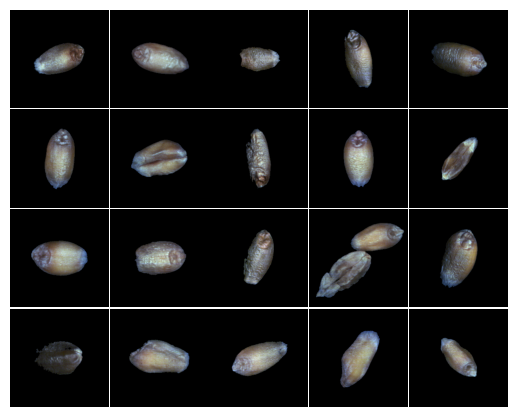

In [10]:
plot_random_data(files=data_files_rgb, dir=DATA_DIR)

In [11]:
df['year'].value_counts()

year
2020    13611
2021    13271
Name: count, dtype: int64

In [12]:
# Split data by year

X_2021 = df[df["year"] == "2021"]
X_2020 = df[df["year"] == "2020"]

In [13]:
X_2021.shape, X_2020.shape

((13271, 8), (13611, 8))

In [17]:
X_2020.to_csv("../Data/Grain-Data-RGB-2020.csv", index=False)
X_2021.to_csv("../Data/Grain-Data-RGB-2021.csv", index=False)

In [15]:
X_2020.drop(columns=['year'], inplace=True)
X_2021.drop(columns=['year'], inplace=True)

/var/folders/dp/ptmdptw102qfsw6n40jzf7zw0000gn/T/ipykernel_46751/3293349378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2020.drop(columns=['year'], inplace=True)
/var/folders/dp/ptmdptw102qfsw6n40jzf7zw0000gn/T/ipykernel_46751/3293349378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2021.drop(columns=['year'], inplace=True)


In [21]:
from sklearn.model_selection import train_test_split


In [18]:
X_2021_label = X_2021['varietyNumber']
X_2021_X = X_2021.drop(columns=['varietyNumber'])

In [22]:
X_train_2021_pb, X_test_2021_pr,Y_pb, Y_pr = train_test_split(X_2021_X, X_2021_label, stratify=X_2021_label, test_size=0.2, random_state=42)

In [23]:
X_test_2021_pr.shape,X_train_2021_pb.shape

((2655, 6), (10616, 6))

In [24]:
X_2020_label = X_2020['varietyNumber']
X_2020_X = X_2020.drop(columns=['varietyNumber'])

In [25]:
X_train_2020_pb, X_test_2020_pr,Y_pb, Y_pr = train_test_split(X_2020_X, X_2020_label, stratify=X_2020_label, test_size=0.2, random_state=42)

In [26]:
X_test_2020_pr.shape,X_train_2020_pb.shape

((2723, 6), (10888, 6))

In [27]:
X_train_2021_pb.to_csv("../Data/X_train_2021_pb.csv", index=False)
X_test_2021_pr.to_csv("../Data/X_test_2021_pr.csv", index=False)
X_train_2020_pb.to_csv("../Data/X_train_2020_pb.csv", index=False)
X_test_2020_pr.to_csv("../Data/X_test_2020_pr.csv", index=False)

In [37]:
file_name="/Users/moujar/Dev/ParisSaclay/T3/AIChal/Grain-Challenge-M1-AI/data/file.txt"
file_array = []
with open(file_name, "r") as f:
    while True:
        a = f.readline()
        if not a:
            break
        file_array.append(a.strip())


In [40]:
import shutil
DATA_DIR = '../data/Grain-Data-RGB/'
for file in os.listdir(DATA_DIR):
    if file in X_train_2021_pb['filename'].values or file in X_train_2020_pb['filename'].values:
        shutil.copy(os.path.join(DATA_DIR, file), '../data/pb')
    else:
        shutil.copy(os.path.join(DATA_DIR, file), '../data/pr')